# Predict Sales of BigMart
**In this Notebook will look at how can we use Neural Network Regressor, to predict the Sales of BigMart**

# Load Neccessary Packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
pd.set_option('display.max_columns', 100)
%matplotlib inline

# Load Train Data

In [3]:
train = pd.read_csv(r'../input/bigmart-sales-data/Train.csv')

In [4]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


# Pre-processing & EDA

In [5]:
train.Item_Fat_Content.value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [6]:
# Correct the Fat Content type
train.replace({'LF': 'Low Fat', 'reg': 'Regular', 'low fat': 'Low Fat'}, inplace=True)

In [7]:
# Replace all spaces with '_' -- This is important as it will require for Neural Networks
cat_columns = train.select_dtypes('object').columns
train[cat_columns] = train[cat_columns].apply(lambda x: x.str.replace(' ', '_'))
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low_Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier_1,Supermarket_Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft_Drinks,48.2692,OUT018,2009,Medium,Tier_3,Supermarket_Type2,443.4228
2,FDN15,17.50,Low_Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier_1,Supermarket_Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits_and_Vegetables,182.0950,OUT010,1998,NaN,Tier_3,Grocery_Store,732.3800
4,NCD19,8.93,Low_Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier_3,Supermarket_Type1,994.7052


# Impute the Missing Values

In [8]:
train.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

### Imputing For Outlet_Size

In [9]:
train.groupby(['Outlet_Type', 'Outlet_Size'], dropna=False).aggregate({'Outlet_Size': 'size'}).unstack()

Outlet_Size                       
Outlet_Size              High Medium   Small     NaN
Outlet_Type                                         
Grocery_Store             NaN    NaN   528.0   555.0
Supermarket_Type1       932.0  930.0  1860.0  1855.0
Supermarket_Type2         NaN  928.0     NaN     NaN
Supermarket_Type3         NaN  935.0     NaN     NaN

**All Grocery Store are small stores**

In [10]:
train.groupby(['Outlet_Location_Type', 'Outlet_Size'], dropna=False).aggregate({'Outlet_Size': 'size'}).unstack()

Outlet_Size                        
Outlet_Size                 High  Medium   Small     NaN
Outlet_Location_Type                                    
Tier_1                       NaN   930.0  1458.0     NaN
Tier_2                       NaN     NaN   930.0  1855.0
Tier_3                     932.0  1863.0     NaN   555.0

**All Tier 2 stores are small stores**

In [11]:
train.groupby(['Outlet_Location_Type','Outlet_Type', 'Outlet_Size'], dropna=False).aggregate({'Outlet_Size': 'size'}).unstack()

Outlet_Size                      
Outlet_Size                                   High Medium  Small     NaN
Outlet_Location_Type Outlet_Type                                        
Tier_1               Grocery_Store             NaN    NaN  528.0     NaN
                     Supermarket_Type1         NaN  930.0  930.0     NaN
Tier_2               Supermarket_Type1         NaN    NaN  930.0  1855.0
Tier_3               Grocery_Store             NaN    NaN    NaN   555.0
                     Supermarket_Type1       932.0    NaN    NaN     NaN
                     Supermarket_Type2         NaN  928.0    NaN     NaN
                     Supermarket_Type3         NaN  935.0    NaN     NaN

**Final Wordict: Impute all missing Outlet_Size as 'Small'**

In [12]:
# Impute all missing Outlet_Size as 'Small'
train.Outlet_Size.fillna('Small', inplace=True)

### Imputing For Item_Weight

In [13]:
# Item_Weight is depend on 'Item_Fat_Content', 'Item_Type'
train[['Item_Weight', 'Item_Fat_Content', 'Item_Type']]

,Item_Weight,Item_Fat_Content,Item_Type
0,9.300,Low_Fat,Dairy
1,5.920,Regular,Soft_Drinks
2,17.500,Low_Fat,Meat
3,19.200,Regular,Fruits_and_Vegetables
4,8.930,Low_Fat,Household
...,...,...,...
8518,6.865,Low_Fat,Snack_Foods
8519,8.380,Regular,Baking_Goods
8520,10.600,Low_Fat,Health_and_Hygiene
8521,7.210,Regular,Snack_Foods


In [14]:
# Compute mean mask w.r.t 'Item_Fat_Content', 'Item_Type'
weight_mask = train.groupby(['Item_Fat_Content', 'Item_Type']).aggregate({'Item_Weight':'mean'})
weight_mask.columns = ['Mean_Item_Weight']
weight_mask.reset_index(inplace=True)
weight_mask.head()

,Item_Fat_Content,Item_Type,Mean_Item_Weight
0,Low_Fat,Baking_Goods,12.552996
1,Low_Fat,Breads,12.429912
2,Low_Fat,Breakfast,11.849412
3,Low_Fat,Canned,11.864650
4,Low_Fat,Dairy,13.391497


In [15]:
impute_weights = train[['Item_Weight', 'Item_Fat_Content', 'Item_Type']]
impute_weights = impute_weights[pd.isnull(impute_weights.Item_Weight)]. \
    merge(weight_mask, how='left', left_on=['Item_Fat_Content', 'Item_Type'], right_on=['Item_Fat_Content', 'Item_Type'])
impute_weights = impute_weights.Mean_Item_Weight
impute_weights

0       13.707177
1       11.400328
2       12.013303
3       12.552996
4       12.804289
          ...    
1458    11.963444
1459    11.963444
1460    13.853285
1461    13.708363
1462    13.384736
Name: Mean_Item_Weight, Length: 1463, dtype: float64

In [16]:
# Impute all missing Item_Weight as mean w.r.t 'Item_Fat_Content', 'Item_Type'
train.loc[pd.isnull(train.Item_Weight), 'Item_Weight'] = impute_weights.values

# Data Preparation

In [17]:
# The First 2 characters of ID, represents the Category type

#Extract the first two characters of ID:
train['Item_Type_Combined'] = train['Item_Identifier'].apply(lambda x: x[0:2])
#Renaming the categories:
train['Item_Type_Combined'] = train['Item_Type_Combined'].map({'FD':'Food',
                                                             'NC':'Non-Consumable',
                                                             'DR':'Drinks'})
train['Item_Type_Combined'].value_counts()

Food              6125
Non-Consumable    1599
Drinks             799
Name: Item_Type_Combined, dtype: int64

In [18]:
# Drop Unnecessary Features
train_new = train.drop(['Item_Identifier', 'Outlet_Identifier', 'Outlet_Establishment_Year'], axis=1)
train_new.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Type_Combined
0,9.30,Low_Fat,0.016047,Dairy,249.8092,Medium,Tier_1,Supermarket_Type1,3735.1380,Food
1,5.92,Regular,0.019278,Soft_Drinks,48.2692,Medium,Tier_3,Supermarket_Type2,443.4228,Drinks
2,17.50,Low_Fat,0.016760,Meat,141.6180,Medium,Tier_1,Supermarket_Type1,2097.2700,Food
3,19.20,Regular,0.000000,Fruits_and_Vegetables,182.0950,Small,Tier_3,Grocery_Store,732.3800,Food
4,8.93,Low_Fat,0.000000,Household,53.8614,High,Tier_3,Supermarket_Type1,994.7052,Non-Consumable


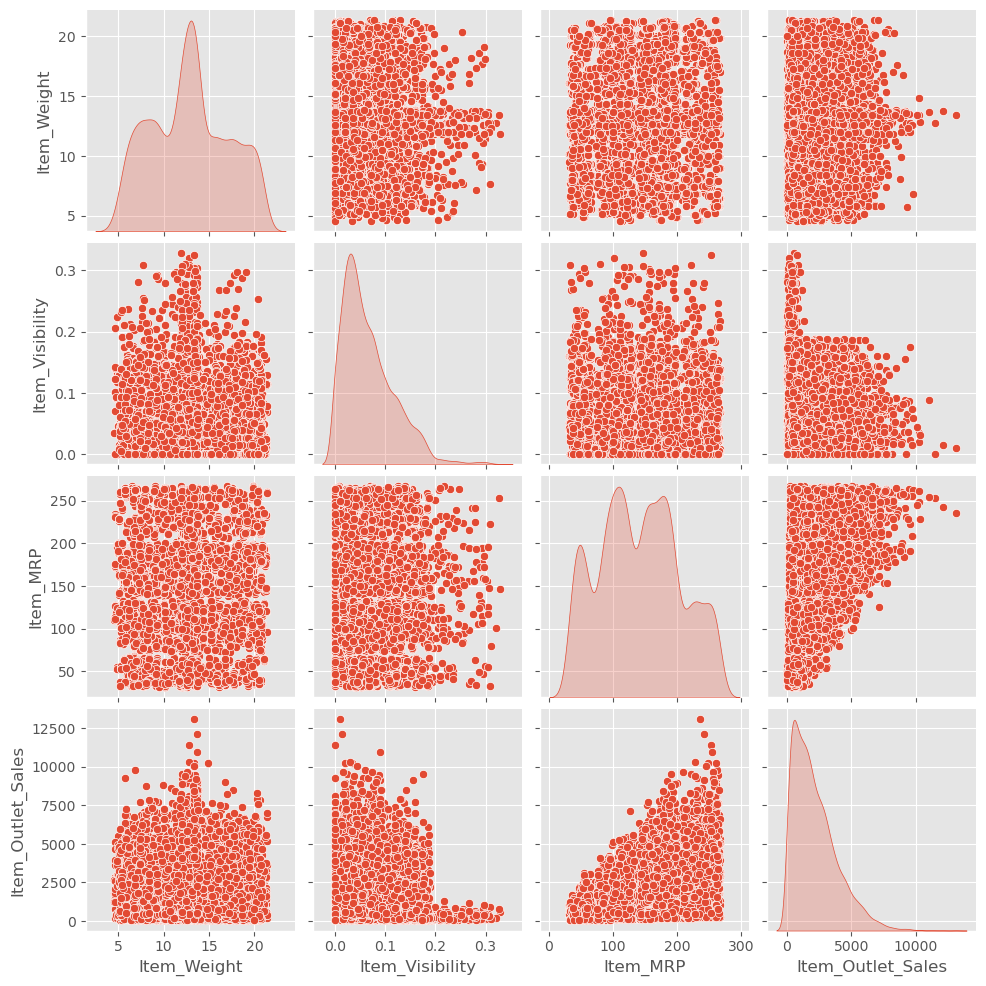

In [19]:
sns.pairplot(train_new, diag_kind='kde')
plt.show()

- Mostly all features have uniform distribution, seems no relation in particular
- Sales of items having higher Item_Visibility > 0.2, Sales tend to be lower
- Item_MRP and Item_Visibility might be good candidate for predicting Item_Outlet_Sales

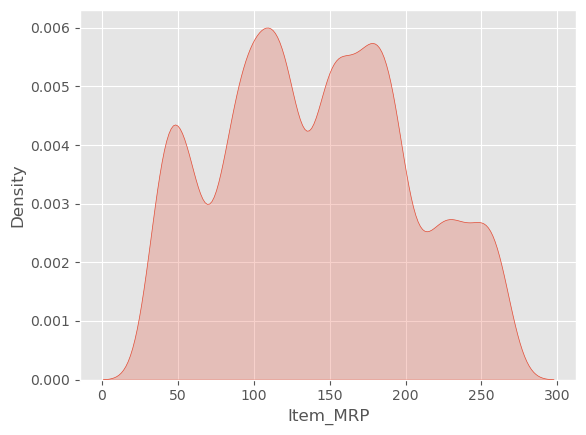

In [20]:
sns.kdeplot(train_new.Item_MRP, fill=True)
plt.show()

**Multi-modal plot - Can be grouped**

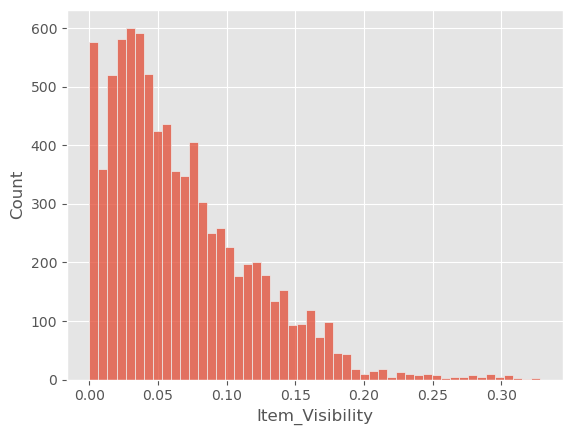

In [21]:
sns.histplot(train_new.Item_Visibility)
plt.show()

**Mostly Items have visibility < 0.1**

# Split feature and target column

In [22]:
X = train_new.drop('Item_Outlet_Sales', axis=1)
y = train_new['Item_Outlet_Sales']

# Embedding Layers

There are couple of ways to handle the categorical features, this includes;
- One Hot Encodding
- Categorical Embedding Layers

Check out my notebook on Embedding Layers: https://www.kaggle.com/code/lunaticsain/docs-embedding-layer-keras

**For this problem, will use Embedding Layers**

In [23]:
X.dtypes

Item_Weight             float64
Item_Fat_Content         object
Item_Visibility         float64
Item_Type                object
Item_MRP                float64
Outlet_Size              object
Outlet_Location_Type     object
Outlet_Type              object
Item_Type_Combined       object
dtype: object

### Seperating numerical and categorical columns

In [24]:
num_columns = X.select_dtypes(['int', 'float']).columns
cat_columns = X.select_dtypes('object').columns
num_columns, cat_columns

(Index(['Item_Weight', 'Item_Visibility', 'Item_MRP'], dtype='object'),
 Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Size', 'Outlet_Location_Type',
        'Outlet_Type', 'Item_Type_Combined'],
       dtype='object'))

## Validation

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Deep Neural Network Model using Tensorflow

In [26]:
import tensorflow as tf

In [27]:
feature_columns = []

# for categorical features
for feature_name in cat_columns:
    vocabulary = X[feature_name].unique()
    
    # define categorical column
    feature_col = tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary)

    # wrap categorical column in an embedding column
    feature_col_embed = tf.feature_column.embedding_column(feature_col, dimension=5)

    # add the embedding column to the feature columns list
    feature_columns.append(feature_col_embed)
    
# for numerical features
for feature_name in num_columns:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

feature_columns

[EmbeddingColumn(categorical_column=VocabularyListCategoricalColumn(key='Item_Fat_Content', vocabulary_list=('Low_Fat', 'Regular'), dtype=tf.string, default_value=-1, num_oov_buckets=0), dimension=5, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x7fd6f8493450>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, trainable=True, use_safe_embedding_lookup=True),
 EmbeddingColumn(categorical_column=VocabularyListCategoricalColumn(key='Item_Type', vocabulary_list=('Dairy', 'Soft_Drinks', 'Meat', 'Fruits_and_Vegetables', 'Household', 'Baking_Goods', 'Snack_Foods', 'Frozen_Foods', 'Breakfast', 'Health_and_Hygiene', 'Hard_Drinks', 'Canned', 'Breads', 'Starchy_Foods', 'Others', 'Seafood'), dtype=tf.string, default_value=-1, num_oov_buckets=0), dimension=5, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x7fd6f8493590>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, trainable=True, u

The `dimension` parameter in the embedding_column specifies the dimensionality of the embedding space. It means that each categorical feature will be mapped to a vector of dimensionality 5 in this case.

The choice of dimensionality is a hyperparameter that needs to be tuned during the model development process. A higher dimensionality will provide more flexibility in capturing complex relationships between features, but will also increase the computational cost of training the model. A lower dimensionality may be insufficient to capture all relevant information in the data. In practice, the optimal dimensionality may depend on factors such as the size of the dataset, the complexity of the problem, and the quality of the input features.

### Make input function to feed for model

In [28]:
def make_input_fn(data_df, label_df, num_epochs=10, batch_size=32, shuffle=True):
    def input_function():
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df)) #create tf.data.Dataset object with data & its label
        if shuffle:
            ds = ds.shuffle(1000) #shuffle data set
        ds = ds.batch(batch_size).repeat(num_epochs) #split dataset into batches, repeat it for number of epochs
        return ds #return batch of ds
    return input_function #return the function object for use

In [29]:
# build train and test input function
train_input_fn = make_input_fn(X_train, y_train)
test_input_fn = make_input_fn(X_test, y_test, num_epochs=1, shuffle=False) # as this is testing we need only 1 epoch and we don't need to shuffle

### Train DNN

In [30]:
DNNmodel = tf.estimator.DNNRegressor(
    feature_columns=feature_columns,
    hidden_units = [30, 15, 10, 15, 30],  # 2 hidden layers w/ 30 and 10 nodes resp.
    optimizer='Adam',
    activation_fn='relu'
)

DNNmodel.train(input_fn = train_input_fn, steps=3000)

### Evaluate

In [31]:
result = DNNmodel.evaluate(test_input_fn)
result

{'average_loss': 1067912.8,
 'label/mean': 2097.008,
 'loss': 1060331.4,
 'prediction/mean': 2064.9807,
 'global_step': 2140}

### Predict

In [32]:
from sklearn.metrics import r2_score
y_pred = DNNmodel.predict(test_input_fn)
y_pred = list(y_pred)

# extract the predicted values
y_predict = []
for elem in y_pred:
    y_predict.append(elem['predictions'][0])
    
print("R2 Score:", r2_score(y_test, y_predict))

R2 Score: 0.6070917346178492


# Summary

The Data is uniform, and a trend is harder to find.

The models I have run previously, gave somewhat similar result:
    
    - CatBoost: ~ 0.58
    - XGBoost: ~ 0.55
    - Neural Networks w/ One Hot Encoding: ~ 0.6
    - Deep Neural Networks w/ Embedding Layer: ~ 0.6


# Please leave an upvote, if you found this notebook helpful! 👍